In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import seaborn as sns
pd.set_option('display.max_rows', 100)


<!-- **Предобработка данных** (заполнение пропусков, кодирование категориальных признаков) сильно влияет на результат.

**Feature engineering**(создание новых признаков, например, «семейный размер») может улучшить модели.

**Оценка качества:** Используйте accuracy, F1-score, ROC-AUC (особенно если классы несбалансированы). -->

In [4]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the Data
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

# Data Preprocessing
Firstly we should delete all the NaN values in the Columns:


*   Age (20% missed, use CatBoostRegressor to fill NaNs)
*   Embarked (2 missed, fill by most frequent category - 'S')



In [6]:
train_prep = train_data.copy()
test_data = test_data.fillna({'Fare': test_data['Fare'].median()})

# Get NEW feature - Title (Handle from the Name)
def get_Title(data):
    data.Embarked = train_prep.Embarked.fillna('S')
    common_titles = ['Mr', 'Mrs', 'Miss', 'Master'] # most frequent titles
    data['Title'] = data['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
    data['Title'] = data['Title'].replace({
                                          'Mlle': 'Miss',
                                          'Ms': 'Miss',
                                          'Mme': 'Mrs'
                                          })

    # Less frequent titles are replaced by 'Rare'
    data['Title'] = data['Title'].apply(lambda x: x if x in common_titles else 'Rare')
    return data

train_prep = get_Title(train_prep)
test_data = get_Title(test_data)

# Missing Age filling
In case that 20% of the train_data hasn't the information about the Ages, I use Catboost to solve this

In addition, I will use this model to the test_data

In [10]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from joblib import dump, load


# Clearify the feature names
cat_features = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Title']
cont_features = ['Fare']
features = cat_features + cont_features

# Split the Train_Dataset by NaN and NotNaN values
Age_train = train_prep[train_prep['Age'].notnull()]
Age_test = train_prep[train_prep['Age'].isnull()]

# Declare the traget and features
X_train_age = Age_train[features]
Y_train_age = Age_train['Age']
X_test_age = Age_test[features]

# The model iiiiiiissss..
Age_model = CatBoostRegressor(verbose=False)

# Grid of the parameters for tuning
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': uniform(1, 10),
    'iterations': randint(100, 500),
    'bagging_temperature': uniform(0, 1),
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=Age_model,
    param_distributions=param_dist,
    n_iter=2,
    cv=5,
    scoring='neg_root_mean_squared_error',  # для регрессии RMSE
    verbose=2,
    n_jobs=-1
)

# CV_fit-predict
random_search.fit(X_train_age, Y_train_age, cat_features=cat_features)
print("Best RMSE:", -random_search.best_score_)

# Save the best model (in case we use this model predictions many times)
best_Age_model = random_search.best_estimator_
dump(best_Age_model, '/content/drive/MyDrive/Colab Notebooks/best_Age_model.joblib')

# Applying predictions to the train Dataset
Age_model = load('/content/drive/MyDrive/Colab Notebooks/best_Age_model.joblib')
Age_pred_train = Age_model.predict(X_test_age) # predict Age for the train part
Age_pred_test = Age_model.predict(test_data[test_data['Age'].isnull()][features]) # predict Age for the test part (that contains NaN)

# Finally filling the NaNs
train_prep.loc[train_prep['Age'].isnull(), 'Age'] = Age_pred_train
test_data.loc[test_data['Age'].isnull(), 'Age'] = Age_pred_test


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best RMSE: 9.969162426315872


No objects info loaded
No objects info loaded


# Get our baseline - Logistic Regression

In [45]:
# Load Dataset
X_train = train_prep.copy()
Y_train = train_prep['Survived']
X_test = test_data.copy()

# Prepare raw features
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

In [46]:
from sklearn.linear_model import LogisticRegression

LRegressor = LogisticRegression()
LRegressor.fit(X_train[num_features], Y_train)
LRegressor_pred = LRegressor.predict(X_test[num_features])

# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': LRegressor_pred})
# output.to_csv('submission.csv', index=False)
# files.download('submission.csv')

# Baseline Score: 0.66267


# Function to Evaluate the model
   ## metrics:
*   Accuracy
*   F1-score
*   ROC-AUC
*   Precision
*   Recall



In [35]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def model_eval(model, X, Y, model_name=None, cv=5, verbose=True):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    results = cross_validate(
        estimator=model,
        X=X,
        y=Y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    summary = {
        'Model': model_name or type(model).__name__,
        'Accuracy': round(results['test_accuracy'].mean(), 4),
        'Precision': round(results['test_precision'].mean(), 4),
        'Recall': round(results['test_recall'].mean(), 4),
        'F1': round(results['test_f1'].mean(), 4),
        'ROC AUC': round(results['test_roc_auc'].mean(), 4)
    }

    if verbose:
        print(f"  🔍 Evaluation for model: {summary['Model']}")
        print(f"  ✅ Accuracy  = {summary['Accuracy']}")
        print(f"  🎯 Precision = {summary['Precision']}")
        print(f"  📡 Recall    = {summary['Recall']}")
        print(f"  ⚖️ F1-score  = {summary['F1']}")
        print(f"  🧠 ROC-AUC   = {summary['ROC AUC']}")

    # Split the Data into train and validation parts
    X_train, X_val, Y_train, Y_val = train_test_split(
                                                      X,
                                                      Y,
                                                      test_size=0.2,
                                                      random_state=42
                                                      )

    # Fit our model and get predictions for the ROC-AUC
    model.fit(X_train, Y_train)
    Y_proba = model.predict_proba(X_val)[:, 1]

    # Get the Curve
    fpr, tpr, thresholds = roc_curve(Y_val, Y_proba)
    roc_auc = auc(fpr, tpr)

    # Visualization
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Случайная модель')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return pd.DataFrame([summary])

  🔍 Evaluation for model: LogisticRegression
  ✅ Accuracy  = 0.6993
  🎯 Precision = 0.7589
  📡 Recall    = 0.319
  ⚖️ F1-score  = 0.4479
  🧠 ROC-AUC   = 0.7075


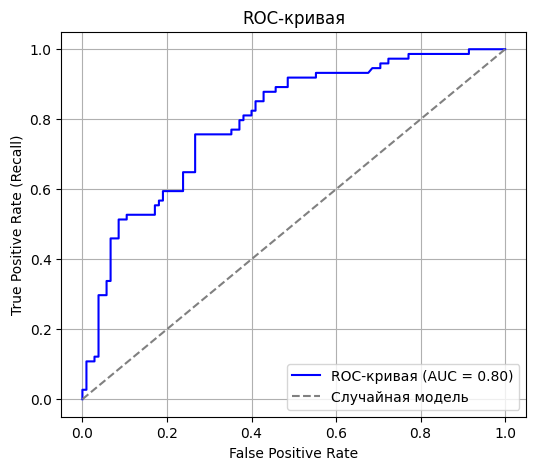

In [36]:
LRegressor_results_df = model_eval(LRegressor, X_train[num_features], Y_train, verbose=True)

# The second model – RandomForestRegressor

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# Scaler + One_Hot_Encoder = Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Full Pipeline
RF_clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])



# Hyperparameters distributions in the pipeline
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 20),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2', None],
}

# RF_CV
RF_random_search = RandomizedSearchCV(
    estimator=RF_clf_pipeline,
    param_distributions=param_dist,
    n_iter=60,                 # Change then!!!!!
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Find the best model and save it
RF_random_search.fit(X_train, Y_train)
best_RF_model = RF_random_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


  🔍 Evaluation for model: RandomForestClassifier
  ✅ Accuracy  = 0.8204
  🎯 Precision = 0.807
  📡 Recall    = 0.6986
  ⚖️ F1-score  = 0.7478
  🧠 ROC-AUC   = 0.8742


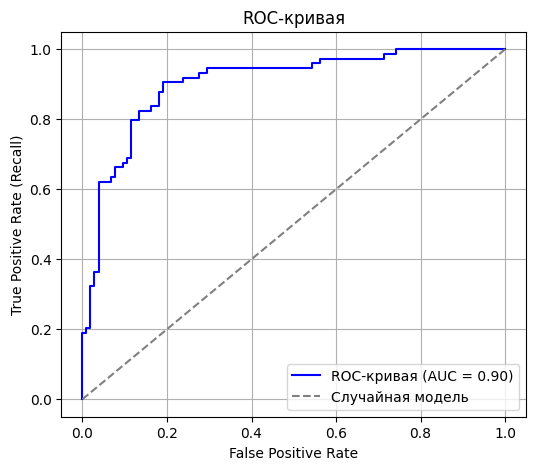

In [61]:
# Eval the Model
RF_clf_results_df = model_eval(best_RF_model, X_train, Y_train, model_name='RandomForestClassifier',  verbose=True)

In [58]:
# Get predictions and submit them
RF_pred = best_RF_model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': RF_pred})
output.to_csv('RF_submission.csv', index=False)
files.download('RF_submission.csv')

# Score: 0.79186

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>